In [47]:
import matplotlib.pyplot as plt
import geopandas as gpd
import sys
sys.path.append('../_amigocloud')
from amigocloud import AmigoCloud
import rasterio
from rasterio.plot import show
import numpy as np
from shapely import wkb

from matplotlib.lines import Line2D
from matplotlib.patches import Patch

In [38]:
# leer token
acceso = open(ruta + '/_keys/api_amigocloud.key','r')
api_token = acceso.readlines()[0]
acceso.close()
amigocloud = AmigoCloud(token=api_token)
amigocloud

In [7]:
cod_prop = 299
unidad = 'G:'

In [12]:
# ruta de carpera donde estan las llaves
ruta = open('../ruta.txt')
ruta = ruta.readlines()[0]
ruta

'G:\\OneDrive - Ingenio Azucarero Guabira S.A\\_DATOS_PYTHON'

In [27]:
path_shp_cat = unidad + r'\Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - EQUIPO AVIACION UTEA\Pulverizacion\2025\SHP\catastro_S09_MIERCOLES.shp'
path_xlsx_mezclas = unidad + r'\Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - EQUIPO AVIACION UTEA\Pulverizacion\PARTE DIARIO PULVERIZACION.26_08.xlsx'
path_xlsx_agua = ''

In [29]:
gdf_cat = gpd.read_file(path_shp_cat)

In [44]:
def convertir_wkb(wkb_data):
    return wkb.loads(wkb_data, hex=True)

In [103]:
def generar_plano_pulv(shp_prop, path_tif, path_out):
    # Cargar la imagen TIFF con rasterio
    with rasterio.open(path_tif) as src:
        extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]  # Límites geoespaciales
        img = src.read([1, 2, 3])  # Leer las bandas RGB
    
    # Crear el plano
    fig, ax = plt.subplots(figsize=(15, 15))
    
    # Mostrar la imagen de fondo (TIFF) con coordenadas georreferenciadas
    show(img, transform=src.transform, ax=ax)
    
    #facecolor=(R, G, B, Alpha)
    shp_prop.plot(ax=ax, edgecolor='blue', facecolor=(0, 0, 0, 0), linewidth=1)

    # Agregar etiquetas con lote mas area
    for idx, row in shp_prop.iterrows():
        if row.geometry is not None:
            label = f"{row['unidad_05']}\n{round(row['area'], 2)} ha"
            centroid = row.geometry.representative_point()  # Mejor que .centroid en algunos casos
            ax.text(centroid.x, centroid.y, label, fontsize=7, ha='center', color='black', weight=1000,
                    bbox=dict(facecolor='white', edgecolor='none', alpha=0.2, pad=0))

    # Configurar título
    nom_prop = shp_prop["unidad_02"].iloc[0]
    ax.set_title(nom_prop, fontsize=14)

    # 🔍 **Ajustar los límites del mapa para hacer zoom en la propiedad**
    bounds = shp_prop.total_bounds  # [xmin, ymin, xmax, ymax]
    ax.set_xlim([bounds[0] - 400, bounds[2] + 400])
    ax.set_ylim([bounds[1] - 400, bounds[3] + 400])

    # 🔹 **Agregar Leyenda**
    legend_elements = [
        #facecolor=(R, G, B, Alpha)
        Patch(facecolor=(0, 0, 0, 0), edgecolor='blue', label='Lotes Propiedad')
    ]
    ax.legend(handles=legend_elements, loc='upper right', fontsize=10, frameon=True, facecolor='white', edgecolor='black')

    # Guardar plano
    fig.savefig(path_out, dpi = 300, bbox_inches='tight')
    
    # Mostrar el mapa
    #plt.show()

In [105]:
query = {'query': f'SELECT lotes.*, mez.numero_de_mezcla\
                    FROM dataset_360912 lotes\
                    JOIN dataset_367583 mez\
                      ON ST_Intersects(lotes.geometry, mez.puntos)\
                    WHERE lotes.unidad_01 = {cod_prop}'}

select = amigocloud.get('https://app.amigocloud.com/api/v1/projects/35248/sql', query)
data_apli = select['data']

In [106]:
gdf_lotes_apli = gpd.GeoDataFrame(data_apli)

In [107]:
gdf_lotes_apli['geometry'] = gdf_lotes_apli['geometry'].apply(convertir_wkb)

In [108]:
gdf_lotes_apli.head(3)

,fecha_registro,id,unidad_01,unidad_02,unidad_03,unidad_04,unidad_05,area,geometry,os,amigo_id,numero_de_mezcla
0,2025-03-19 15:16:58.519510+00:00,61,299,CITTCA,1530,C.I.T.T.C.A.,N15.2,1.135417,"MULTIPOLYGON (((-63.19635 -17.23712, -63.19635...",7,fd675e34961e4fcc80777f116286341a,29
1,2025-03-19 15:17:02.506554+00:00,64,299,CITTCA,1530,C.I.T.T.C.A.,C14.1,1.128854,"MULTIPOLYGON (((-63.18731 -17.24305, -63.18731...",7,4bc809347a174f7e98a3e0a4c77943da,30
2,2025-03-19 15:17:06.837458+00:00,67,299,CITTCA,1530,C.I.T.T.C.A.,N15.3,1.196737,"MULTIPOLYGON (((-63.19635 -17.23712, -63.19538...",7,fc7c28d830db46b1b11996d984b6c1c4,29


In [109]:
gdf_lotes_apli = gdf_lotes_apli.set_geometry("geometry")

In [84]:
lotes_apli = gdf_lotes_apli.set_crs("EPSG:32720", inplace=True)

In [57]:
print(lotes_apli.crs)

EPSG:32720


In [68]:
print(prop.crs)

EPSG:32720


In [110]:
gdf_lotes_apli.crs = "EPSG:32720"
lotes_apli = gdf_lotes_apli.to_crs(epsg=32720)

In [31]:
path_out = unidad + r"\OneDrive - Ingenio Azucarero Guabira S.A\_DATOS_PYTHON\planos\plano_aux_preaplicacion.jpg"
path_tif = r"C:\Users\Usuario\Downloads\SENTINEL_2025-02-12_UTM.tif"

In [32]:
prop = gdf_cat[gdf_cat['unidad_01'] == cod_prop]

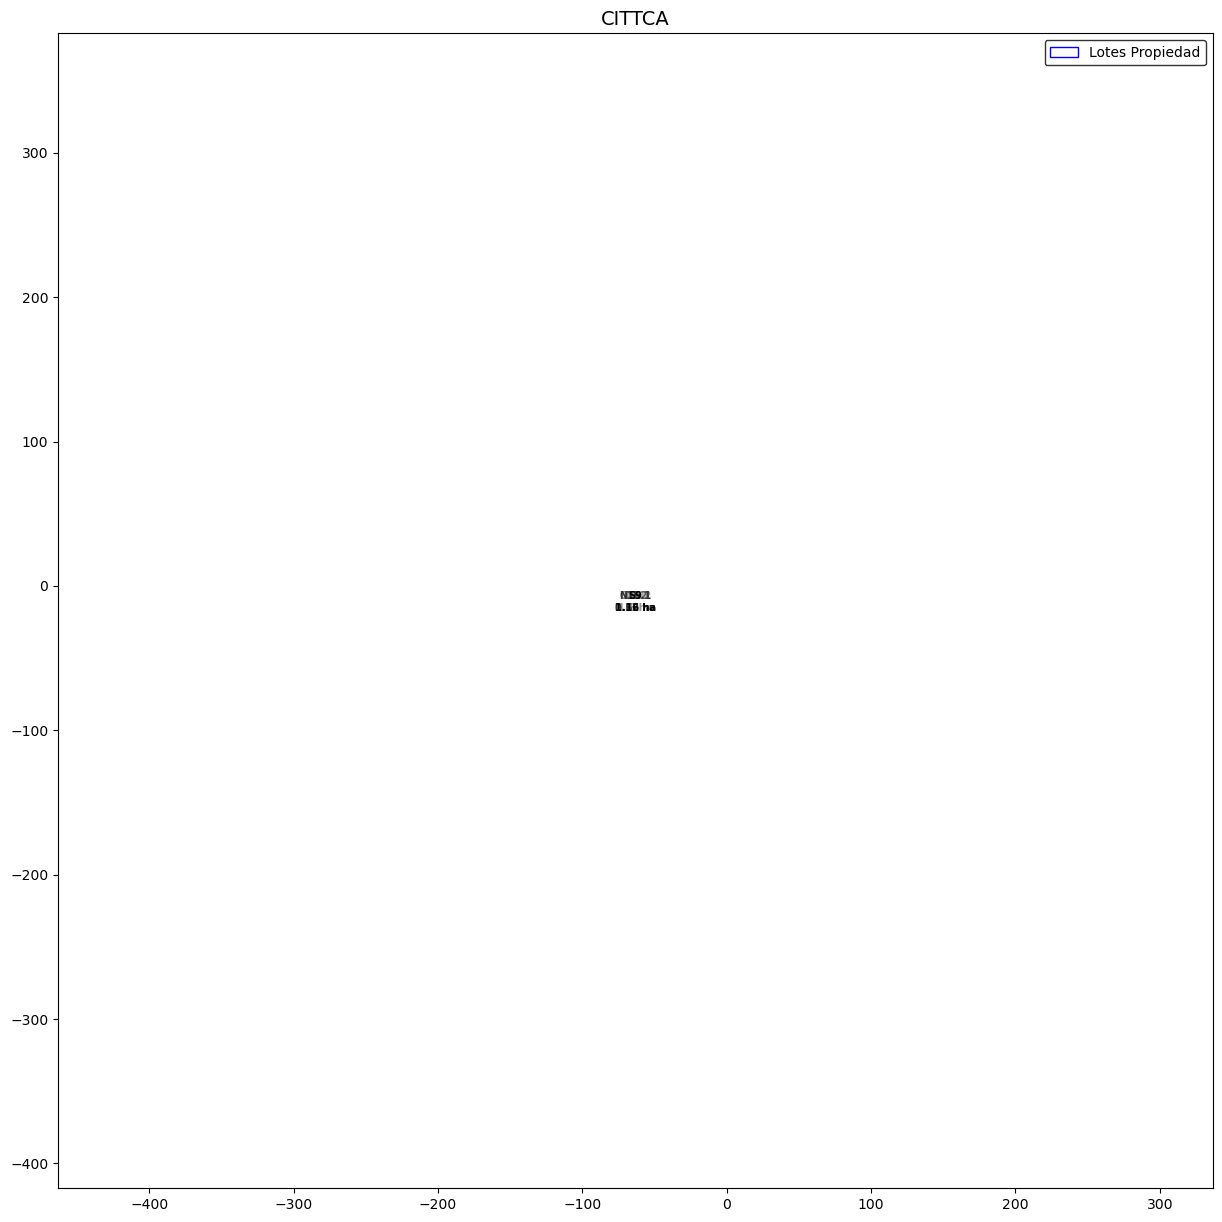

In [111]:
generar_plano_pulv(lotes_apli, path_tif, path_out)